In [15]:
# Import the necessary libs for the homework
import torch
import torch.nn as nn
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.autograd.variable import Variable
import torch.nn.functional as F
torch.autograd.set_detect_anomaly(True)
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils import spectral_norm
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [16]:
# Load the data from the CSV file
data = pd.read_csv('data/sliced_data_pca.csv')

# Create a mask for each range
mask1 = (data['0'] >= -3) & (data['0'] < -1)
mask2 = (data['0'] >= -1) & (data['0'] < 1)
mask3 = (data['0'] >= 1) & (data['0'] < 3)
mask4 = (data['0'] >= 3) & (data['0'] <= 5)

# Use the masks to create the sub dataframes
df1 = data[mask1]
df2 = data[mask2]
df3 = data[mask3]
df4 = data[mask4]

# Calculate the total number of points
total_points = len(data)

# Calculate the probability for each sub-dataframe
prob_df1 = len(df1) / total_points
prob_df2 = len(df2) / total_points
prob_df3 = len(df3) / total_points
prob_df4 = len(df4) / total_points

# Convert the pandas DataFrames to PyTorch Tensors
data_tensor1 = torch.tensor(df1.values, dtype=torch.float32)
data_tensor2 = torch.tensor(df2.values, dtype=torch.float32)
data_tensor3 = torch.tensor(df3.values, dtype=torch.float32)
data_tensor4 = torch.tensor(df4.values, dtype=torch.float32)

# Convert your data to TensorDatasets
dataset1 = TensorDataset(data_tensor1)
dataset2 = TensorDataset(data_tensor2)
dataset3 = TensorDataset(data_tensor3)
dataset4 = TensorDataset(data_tensor4)

# Set the batch size
batch_size = 64

# Create DataLoaders with shuffle=True for shuffling at each epoch
train_loader1 = DataLoader(dataset1, batch_size=batch_size, shuffle=True, drop_last=True)
train_loader2 = DataLoader(dataset2, batch_size=batch_size, shuffle=True, drop_last=True)
train_loader3 = DataLoader(dataset3, batch_size=batch_size, shuffle=True, drop_last=True)
train_loader4 = DataLoader(dataset4, batch_size=batch_size, shuffle=True, drop_last=True)

In [17]:
class Generator(nn.Module):
    def __init__(self, z_dim=2, out_dim=2, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.Linear(hidden_dim * 4, out_dim),
        )

    def forward(self, noise):
        return self.gen(noise)

class Discriminator(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

In [18]:
# Sets the parameters
lr = 0.00001
loss_function = nn.BCELoss()
num_epochs = 1000

In [19]:
def train_gan(train_loader, num_epochs, batch_size, lr):
    discriminator = Discriminator()
    generator = Generator()
    gen_loss_vector = []
    discr_loss_vector = []
    num_epoch_vector = []

    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=2*lr)
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

    losses = []
    for epoch in tqdm(range(num_epochs)):
        for idx, real_data_set in enumerate(train_loader):
            real_data_set = real_data_set[0]
            real_data_label = torch.ones(batch_size,1)

            noise_data_set = torch.randn((batch_size, 2))
            fake_data_set = generator(noise_data_set)
            fake_data_label = torch.zeros(batch_size, 1)

            training_data_set = torch.cat((real_data_set, fake_data_set))
            training_labels_set = torch.cat((real_data_label, fake_data_label))

            discriminator.zero_grad()
            output_discriminator = discriminator(training_data_set)
            loss_discriminator = loss_function(output_discriminator, training_labels_set)
            loss_discriminator.backward()
            optimizer_discriminator.step()

            noise_data_set = torch.randn((batch_size, 2))

            generator.zero_grad()
            output_generator = generator(noise_data_set)
            output_discriminator_generated  = discriminator(output_generator)
            loss_generator = loss_function(output_discriminator_generated, real_data_label)
            loss_generator.backward()
            optimizer_generator.step()

            if idx == batch_size-1:
                gen_loss_vector.append(float(loss_generator))
                discr_loss_vector.append(float(loss_discriminator))
                num_epoch_vector.append(epoch)

            

        losses.append((loss_discriminator.item(), loss_generator.item()))

    return generator, discriminator, losses

# Train a GAN for each DataLoader
generator1, discriminator1, losses1 = train_gan(train_loader1, 2*num_epochs, batch_size, lr)
generator2, discriminator2, losses2 = train_gan(train_loader2, num_epochs, batch_size, lr)
generator3, discriminator3, losses3 = train_gan(train_loader3, 2*num_epochs, batch_size, lr)
generator4, discriminator4, losses4 = train_gan(train_loader4, 2*num_epochs, batch_size, lr)

100%|██████████| 2000/2000 [02:36<00:00, 12.78it/s]


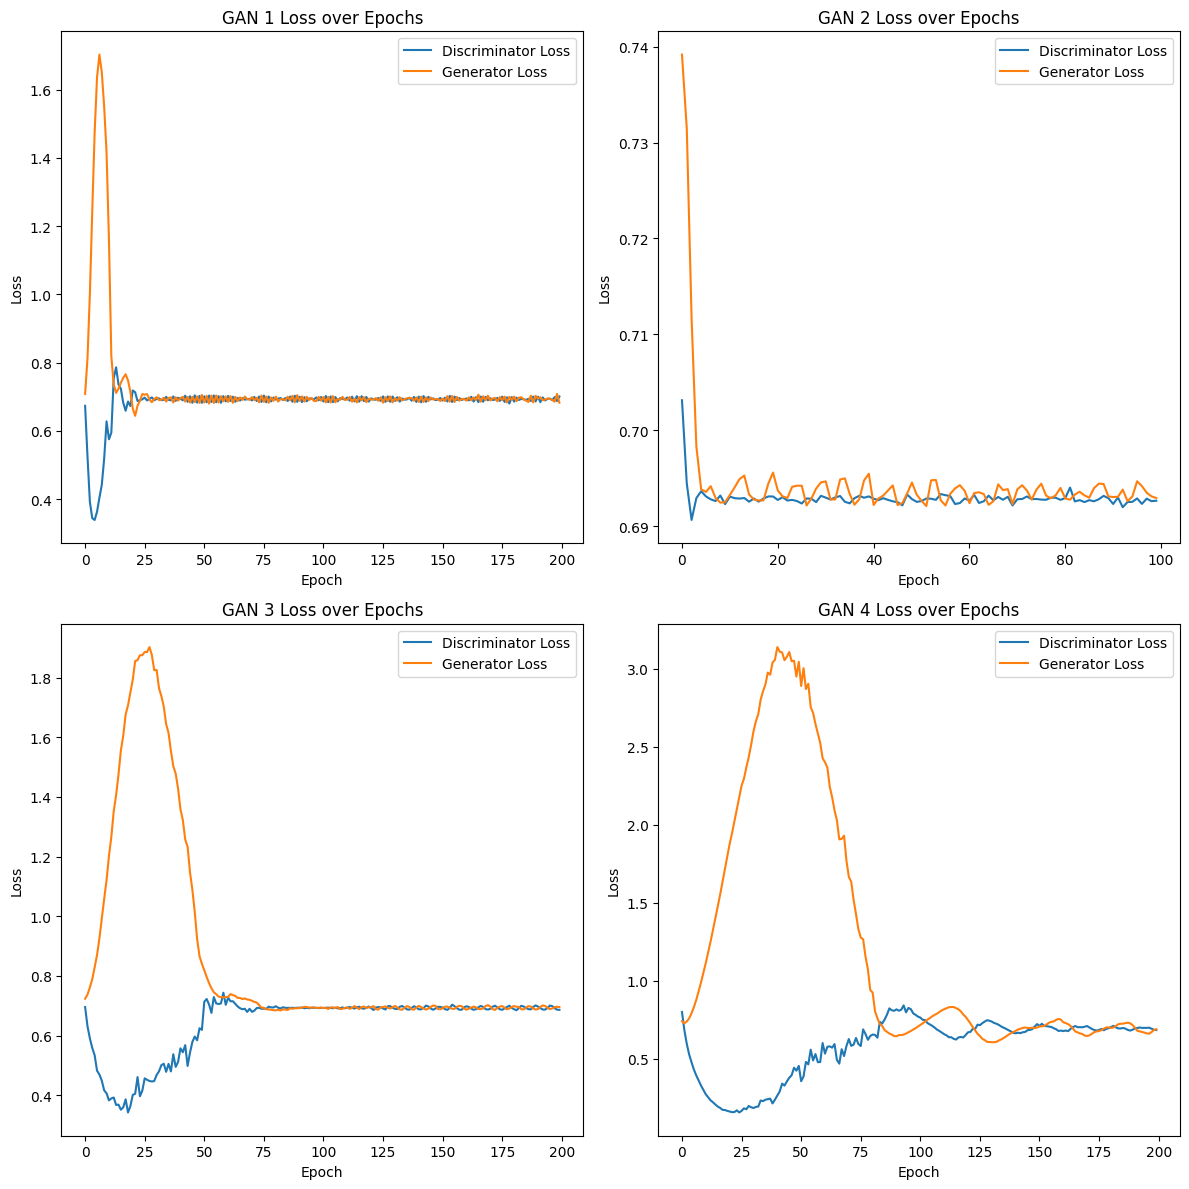

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot the losses for the first GAN
axs[0, 0].plot([i[0] for i in losses1[::10]], label='Discriminator Loss')
axs[0, 0].plot([i[1] for i in losses1[::10]], label='Generator Loss')
axs[0, 0].legend()
axs[0, 0].set_title('GAN 1 Loss over Epochs')

# Plot the losses for the second GAN
axs[0, 1].plot([i[0] for i in losses2[::10]], label='Discriminator Loss')
axs[0, 1].plot([i[1] for i in losses2[::10]], label='Generator Loss')
axs[0, 1].legend()
axs[0, 1].set_title('GAN 2 Loss over Epochs')

# Plot the losses for the third GAN
axs[1, 0].plot([i[0] for i in losses3[::10]], label='Discriminator Loss')
axs[1, 0].plot([i[1] for i in losses3[::10]], label='Generator Loss')
axs[1, 0].legend()
axs[1, 0].set_title('GAN 3 Loss over Epochs')

# Plot the losses for the fourth GAN
axs[1, 1].plot([i[0] for i in losses4[::10]], label='Discriminator Loss')
axs[1, 1].plot([i[1] for i in losses4[::10]], label='Generator Loss')
axs[1, 1].legend()
axs[1, 1].set_title('GAN 4 Loss over Epochs')

# Add labels to the x and y axes of each subplot
for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')

# Display the plot
plt.tight_layout()
plt.show()

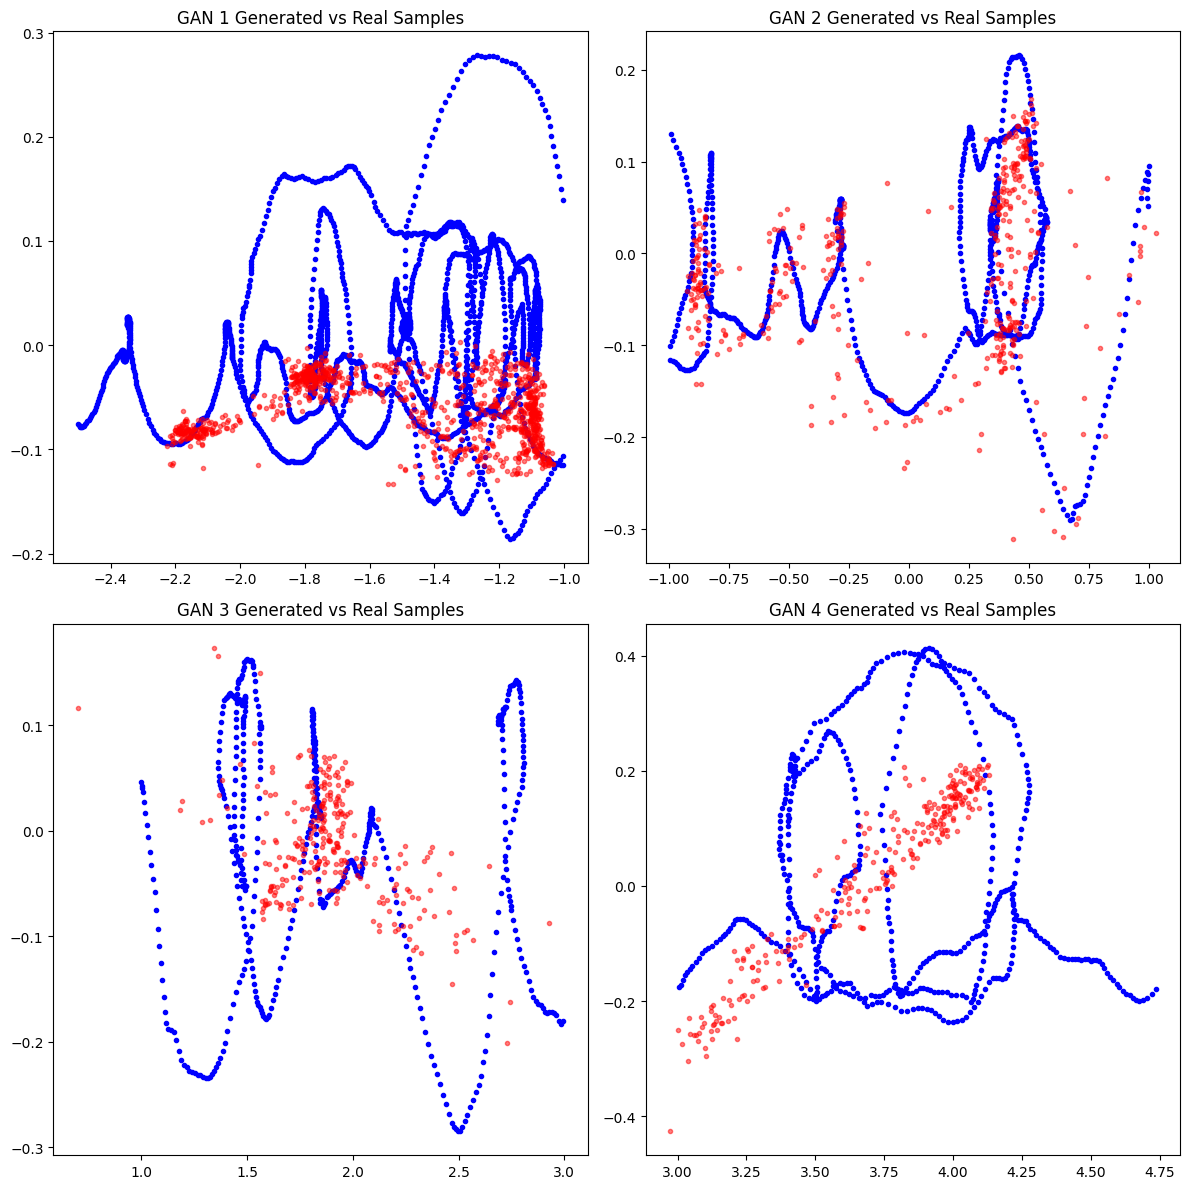

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

num1 = 2*int(1000*prob_df1)
num2 = 2*int(1000*prob_df2)
num3 = 2*int(1000*prob_df3)
num4 = 2*int(1000*prob_df4)

# Generate and plot samples for the first GAN
noise_data_set = torch.randn((num1, 2))
generated_samples1 = generator1(noise_data_set).detach().numpy()
axs[0, 0].plot(data_tensor1[:, 0], data_tensor1[:, 1], ".", color='blue')
axs[0, 0].plot(generated_samples1[:, 0], generated_samples1[:, 1], ".", color='red', alpha=0.5)
axs[0, 0].set_title('GAN 1 Generated vs Real Samples')

# Generate and plot samples for the second GAN
noise_data_set = torch.randn((num2, 2))
generated_samples2 = generator2(noise_data_set).detach().numpy()
axs[0, 1].plot(data_tensor2[:, 0], data_tensor2[:, 1], ".", color='blue')
axs[0, 1].plot(generated_samples2[:, 0], generated_samples2[:, 1], ".", color='red', alpha=0.5)
axs[0, 1].set_title('GAN 2 Generated vs Real Samples')

# Generate and plot samples for the third GAN
noise_data_set = torch.randn((num3, 2))
generated_samples3 = generator3(noise_data_set).detach().numpy()
axs[1, 0].plot(data_tensor3[:, 0], data_tensor3[:, 1], ".", color='blue')
axs[1, 0].plot(generated_samples3[:, 0], generated_samples3[:, 1], ".", color='red', alpha=0.5)
axs[1, 0].set_title('GAN 3 Generated vs Real Samples')

# Generate and plot samples for the fourth GAN
noise_data_set = torch.randn((num4, 2))
generated_samples4 = generator4(noise_data_set).detach().numpy()
axs[1, 1].plot(data_tensor4[:, 0], data_tensor4[:, 1], ".", color='blue')
axs[1, 1].plot(generated_samples4[:, 0], generated_samples4[:, 1], ".", color='red', alpha=0.5)
axs[1, 1].set_title('GAN 4 Generated vs Real Samples')

# Display the plot
plt.tight_layout()
plt.show()

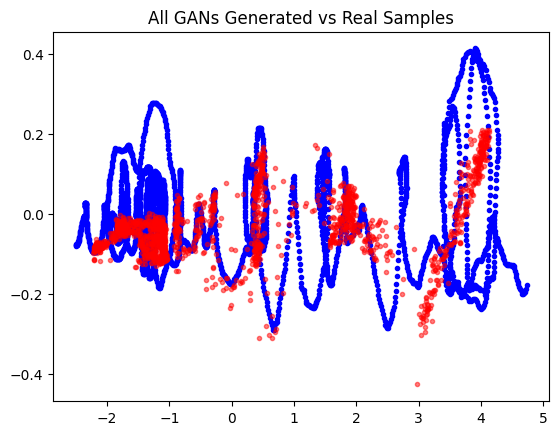

In [22]:
# Concatenate all the generated samples
all_generated_samples = np.concatenate([generated_samples1, generated_samples2, generated_samples3, generated_samples4])

# Plot the generated samples
plt.plot(data['0'], data['1'], ".", color='blue')
plt.plot(all_generated_samples[:, 0], all_generated_samples[:, 1], ".", color='red', alpha=0.5)
plt.title('All GANs Generated vs Real Samples')
plt.show()

# Save the generated samples to a CSV file
np.savetxt('data/GAN3_generated_pca.csv', all_generated_samples, delimiter=',')
